## 0. 사용할 라이브러리 불러오기

In [1]:
!pip install summa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.9 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=1a549b8852a2e22d7585ddb9409857e9cd52de306ec4ee5c89e2bc8403ce68a4
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


 summa가 깔려있지 않으니 새로 인스톨해줍니다.

In [50]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords #상기 3개의 nltk는 불용어처리용
import tensorflow as tf
import summa
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import urllib.request
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. 데이터 불러오기

In [76]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

github url을 통해 바로 data 다운로드 없이 온라인상으로 저장했습니다. 

In [77]:
data.sample(10)

,headlines,text
37889,Man takes Ã¢ÂÂ¹15-lakh loan to screen World C...,A football fan in Assam took a bank loan of Ã¢...
46891,"2,000-year-old Roman 'boxing gloves' dug out i...","UK-based researchers have uncovered Roman ""box..."
31235,I hope I don't trip and fall on red carpet at ...,"Pakistani actress Mahira Khan, who will make h..."
74223,Neymar dribbles past 5 defenders to score goal,"World's most expensive footballer Neymar, maki..."
74426,"No nepotism as RK Studios isn't launching me, ...",Aadar Jain has said he is not a product of nep...
35882,"Court rules farting isn't bullying, dismisses ...",A construction firm employee has lost a $1.8 m...
38527,Bhaiyyuji Maharaj leaves all property to his s...,The police have recovered the second page of s...
75785,Delhi institute rolls back 'biased' hostel tim...,Delhi Technological University has tentatively...
13787,Buffalo meat wrongly printed as beef in Mumbai...,An advertisement by the Brihanmumbai Municipal...
39095,2 men lynched after being mistaken as kidnappe...,Two men were lynched in Assam's Karbi Anglong ...


앞서 아마존 리뷰처럼 text 부분과 summary(headline)부분 으로 나눠져 있으니, 인코더/디코더로 나눠서 진행하면 될 것 같습니다!  
총 몇 개가 있는지 확인해볼까요

In [78]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [79]:
print(data['text'])
print(data['headlines'])

0        Saurav Kant, an alumnus of upGrad and IIIT-B's...
1        Kunal Shah's credit card bill payment platform...
2        New Zealand defeated India by 8 wickets in the...
3        With Aegon Life iTerm Insurance plan, customer...
4        Speaking about the sexual harassment allegatio...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    According to reports, a new version of the 199...
98399    A new music video shows rapper Snoop Dogg aimi...
98400    Madhesi Morcha, an alliance of seven political...
Name: text, Length: 98401, dtype: object
0        upGrad learner switches to career in ML & Al w...
1        Delhi techie wins free food from Swiggy for on...
2        New Zealand end Rohit Sharma-led India's 12-ma...
3        Aegon life iTerm insurance plan helps customer...
4        Have known Hirani for yrs, what if MeToo claim...
               

각 열로 잘 나눠져 있고, 갯수는 98,401개로 약 10만개정도 있으니 데이터 삭제없이 전처리를 진행하도록 합니다.  

## 2. 데이터 전처리(추상적 요약)

### 1) 중복 샘플 및 Null 값 제거  

먼저 혹시 모를 중복 및 null 값을 제거해주도록 합니다.

In [6]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [7]:
hedlines_overlap = data[data['headlines'].duplicated()]
print(hedlines_overlap['headlines'])

3292     Isha Ambani features on February cover of Vogu...
3293     Indian Oil looking for annual deal to buy crud...
32850    David Beckham once scored a 60-yard goal from ...
34227    Sachin once fielded for Pakistan before making...
34518      Iraq launches air strikes against ISIS in Syria
                               ...                        
95135    Parveen Babi was 1st Indian film star on TIME ...
95473    Sachin had not let Sehwag watch 2011 World Cup...
95670    How did the tradition of April Fools' Day orig...
96540    Sachin first opened in ODIs due to Sidhu's 'st...
97489              Who are the richest women in the world?
Name: headlines, Length: 121, dtype: object


역시 기존 98,401개와 다른 숫자를 출력하고 있습니다.  
왜 text와 headlines의 중복제외 숫자가 다른지는 의문입니다...만....  
headlines 중복 데이터 121개를 실제 데이터에서 찾아보니, headlines가 겹치면 text도 중복이라는 것을 확인했습니다. 그럼 먼저 headlines의 중복데이터를 `drop_duplicates()`로 지우고 다시 text의 중복데이터를 확인해봅니다.  

In [8]:
data.drop_duplicates(subset = ['headlines'], inplace=True)

In [9]:
print('전체 샘플수 :', (len(data)))
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

전체 샘플수 : 98280
Text 열에서 중복을 배제한 유일한 샘플의 수 : 98262
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


text가 같은데 headlines가 다르다...?  
이걸 중복으로 봐야할까...? 같은 문장에서 다른 서머리를 뽑아낼 수도 있는거 아닐까?  

한번 실제 데이터를 확인해보자.

In [10]:
text_overlap = data[data['text'].duplicated()]
print(text_overlap['text'])

20754    Safeguard yourself against life's unpleasant s...
44594    Berger Paints has launched Berger Express Pain...
52021    Australia's Anthony Stuart took a hat-trick in...
53578    Former Windies' captain Brian Lara named his f...
53865    Cricket legend Don Bradman reversed the Austra...
53892    German Formula One legend Michael Schumacher, ...
54078    Former Australian leg-spinner Shane Warne was ...
55208    During an El ClÃÂ¡sico match in 2002, Barcelo...
57402    Virender Sehwag was captaining India when he h...
58715    The first-ever official international football...
58934    Windies' Gus Logie was adjudged Man of the Mat...
61055    The first wicket and first catch in Test crick...
61445    Former Australian fast bowler Glenn McGrath, w...
62639    Former batsman Sachin Tendulkar became the fir...
62785    India conceded an ODI against Pakistan on Nove...
78519    A TechCrunch report has claimed that IndiaÃ¢Â...
80355    As many as 54,250 fluorescent-yellow tennis ba.

"Berger Express Painting introduces fast and dust-free home painting"  
"Berger introduces T20 of painting with Express Painting"
등 **같은 내용이지만 summary를 다르게 한 데이터**들을 보니, 이것도 좋은 소스가 되지 않을까 싶다.  
(오히려 더 헷갈리려나..?)  

---

이런걸 **이상치**라고함. 과적합을 줄이기 위해서 이런 노이즈를 일부러 줄 수도있지만, 학습단계에서는 거의 안한다고 한다.  
그럼 지워야겠다...^_^..... 지워주자!

In [11]:
data.drop_duplicates(subset = ['text'], inplace=True)

In [12]:
print('전체 샘플수 :', (len(data)))
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

전체 샘플수 : 98262
Text 열에서 중복을 배제한 유일한 샘플의 수 : 98262
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98262


샘플수와 text, headlines의 수가 같아져 중복값이 없는 것을 확인할 수 있다.  

그리고 있을지 모른 null값을 확인하고 제거해주자.

In [13]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

중복값, null값 모두 없는 것을 확인했다.  
이제 텍스트 정규화 및 불용어를 제거해주자.

### 텍스트 정규화 & 불용어 제거  

데이터가 영문이니 I'll -> I will 처럼 영문에 맞는 정규화 처리를 해주자.  
(이전 실습 데이터 처리에서 이 방법을 알았으면 더 정확한 학습을 하고 데이터를 뽑아낼 수 있지 않을까 아쉬움이 남는다.)

In [14]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have", "yrs": "years"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  121


정규화 준비를 마쳤으니, NLTK의 stopwors를 사용하여 불용어 처리를 해주자.

In [15]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

정규화 및 불용어 처리준비를 마쳤다.  
그리고 이 외에 소문자화, html 태그 제거 등을 전처리 함수를 사용해 적용해주자.  

이번 데이터는 뉴스 텍스트 및 헤드라인으로 리뷰처럼 ummmm 같은 일상어는 나올일이 없으니 관련된 re.sub는 제외하고 적용해주자. 

In [16]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('전처리 함수 준비끝:)')

전처리 함수 준비끝:)


아까 랜덤으로 확인한 데이터에서 â¹ 같이 이상한 내용이 있었는데, 이걸 포함해서 잘 처리되는지 한번 확인해본다.

In [17]:
temp_text = 'it could save $5 billion (nearly â¹33,500 crore) over next seven years,'

print("text: ", preprocess_sentence(temp_text))

text:  could save billion next seven years


옥키! 잘 제거되는 것을 확인했다. 역시 능력이 좋구만.  

함수가 잘 처리하는것을 보았으니, 훈련데이터 전체에 대해 전처리를 수행하자.  
이때, text는 불용어를 제거하고, Headlines의 경우는 불용어를 제거하지 않을 것이니 따로 호출해서 진행하도록 하자. 

In [18]:
clean_text = []
# 전체 Text 데이터에 대한 전처리
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

이제 headlines에 대해서 전처리 함수를 처리할 땐, 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False를 넣어주자

In [19]:
clean_headlines = []
# 전체 Headlines 데이터에 대한 전처리
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("Headlines 전처리 후 결과: ", clean_headlines[:5])

Headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


전처리한 clean_~ 데이터들을 원래 text와 headlines로 넣어주자.  

그리고 전처리 후 혹시라도 빈값을 가진 샘플이 있을 수 있으니 null값으로 처리해 지워주자

In [74]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('null 처리 완료:)')

ValueError: ignored

In [75]:
#null 갯수 확인
data.isnull().sum()

headlines         0
text              0
decoder_input     0
decoder_target    0
dtype: int64

### 2) Train/Test 데이터 나눠주기

---

학습에 사용할 데이터 크기를 결정해주고, 문장의 시작과 끝을 표시해주자.

#### 샘플의 최대 길이 정하기
- 샘플들이 최소/최대/평균 길이 및 분포를 확인한다

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10029309397326
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299444342675704


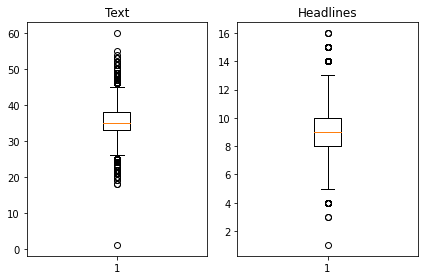

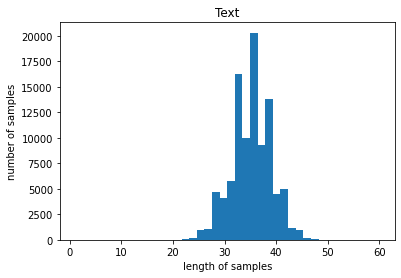

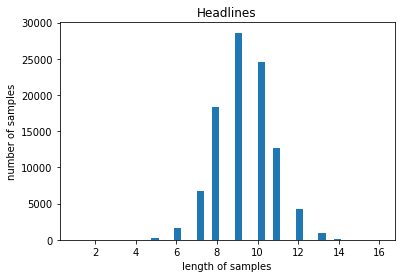

In [22]:
# 길이 분포 출력


text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

Text의 경우
- 최소 길이: 1
- 최대 길이: 60
- 평균 길이: 35  
시각화된 그래프로 봤을 때, 대체적으로 30~40내외의 길이를 가진다는 것을 확인할 수 있다.

Headlines의 경우
- 최소 길이: 1
- 최대 길이: 16
- 평균 길이: 9  
시각화된 그래프로 봤을 때, 대체적으로 8~10 내외의 길이를 가지고 있다는 것을 알 수 있다.

또한 Headlines의 경우 평균길이가 9로 text 원문이 35인것에 비해 약 4배정도 차이가 나는 것을 알 수 있다. 

흠... 저 text에서 길이 1짜리가 튀어서 뭔지 확인해보고 싶다..!  

In [23]:
curious_data = [idx for idx, val in enumerate(text_len) if val <= 5 ]
print(curious_data)

[52]


In [24]:
data.loc[52] 

headlines    headlines
text              text
Name: 52, dtype: object

뭐야... headlines은 headlines이고, text는 text다....   
기자가 일하기 싫었나...?ㅋㅋㅋ 이 값도 잊지않고 제거해주도록 하고, 

이제 어느정도 길이를 정해야 샘플을 많이 자르지 않고 담을 수 있는지 확인해보자. 

우선 임의로 text의 max_len은 50, headlines의 max_len은 14로 정해본다.

In [25]:
#52번 데이터 삭제
data=data.drop([52],axis=0)

In [26]:
text_max_len = 50
headlines_max_len = 14
print('max_len 설정 완료')

max_len 설정 완료


In [27]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('max_len별 샘플 비율 함수 설정 완료:)')

max_len별 샘플 비율 함수 설정 완료:)


In [28]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998575223130235
전체 샘플 중 길이가 14 이하인 샘플의 비율: 0.9997761064918941


각각 max_len 보다 큰 샘플 비율이 약 1%정도다.  
더 잘라내보고 싶지만, 쫄보는 데이터 하나하나가 소중하기때문에... 이대로 진행해본다.

---

@NLP에서 데이터 처리시 n% 이상은 이상비율로 처리해서 자른다는게 논문이나 자료로 나와있으면 그것에 맞춰서 자르고 싶은데,, 나와있지 않으니 결정하기 어렵다.  
정규분포로 따져서 뭐 5%로 자른다 하기엔 정규분포를 따르는게 아니니까...  
그래도 어느정도 boxplot에서 크게 벗어난 데이터는 삭제했다는 생각으로 계속 진행해보기로했다.

In [29]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98225


전체 샘플수 : 98262 -> 98225로 (52번 데이터 포함) 약 37개가 삭제 되었다. 

#### 시작 토큰과 종료 토큰 추가하기

In [30]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


decord의 headlines의 앞에 sostoken이 붙은 input과 뒤에 eostoken이 붙은 target이 생긴것을 확인했다. 이 값들을 다시 NUMPY 타입으로 저장해주자.

---

아.... years의 줄임말인 yrs가 눈에 띈다.... 누네띠네... 요약문에 큰 영향을 주진 않을 것 같아 그냥 넘어가기로한다....    
(아니 한번 처리했는데도 안없어지네...?)
어떻게하면 미리 저런 데이터를 처리해서 시간단축을 시킬 수 있을까?  


In [31]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('인코더/디코더 레이블 입력 완료:)')

인코더/디코더 레이블 입력 완료:)


이제 trainning/validation 데이터를 나누자.   
sklearn을 사용해서 분리해보고 싶었는데, 나눠야할 게 3가지가 되니 조금 머리가 아파 그냥 mix 정수 시퀀스를 만들어서 나눠주자.


In [32]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[91559 63077 22940 ... 91810 21864 65455]


In [33]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('random 샘플 정의 완료:)')

random 샘플 정의 완료:)


이제 섞인 데이터를 8:2의 비율로 train, test로 나눠준다

In [34]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19645


In [35]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78580
훈련 레이블의 개수 : 78580
테스트 데이터의 개수 : 19645
테스트 레이블의 개수 : 19645


encorder/decorder의 input/target 데이터가 잘 나눠진 것을 볼 수 있다. 

이제 vocab 생성 및 정수 인코딩을 진행하자. 

### 3) 정수 인코딩

#### 단어 집합(vocabulary) 만들기 및 정수 인코딩
---
이제 encorder/decorder의 input/target으로 나눠진 묶음에 대해 vocab을 생성하자 

In [36]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('enc_input_train 토크나이저 끝:)')

enc_input_train 토크나이저 끝:)


여기서 빈도수가 낮은 단어들은 훈련데이터에서 제외해 속도 및 정확도를 올려주자

In [37]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69705
등장 빈도가 6번 이하인 희귀 단어의 수: 47538
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22167
단어 집합에서 희귀 단어의 비율: 68.19883795997418
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4886731063047884


약 7만개의 단어 중 47,000여개의 단어(전체 중 68%)가 4%내의 빈도로 등장하여, 상대적으로 적은 빈도의 단어들이 큰 수를 차지하고 있는 것을 알 수 있다.  
따라서 등장 빈도가 7 이하인 단어를 제거해서 vocab의 수를 약 22,000으로 설정하겠습니다.  
(지난 실습을 진행해보니 vocab의 수를 무조건 크게 잡는게 좋은게 아니라는 것을 알았다...!)

In [38]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('vocab 재설정 완료:)')

vocab 재설정 완료:)


In [39]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[128, 31, 50, 1180, 142, 3047, 180, 366, 9130, 4729, 944, 501, 637, 18, 741, 42, 140, 192, 50, 8978, 3537, 369, 2179, 77, 239, 697, 73, 818, 1294, 1415, 142, 1339, 142, 1127, 4730, 10271, 9130, 11561], [919, 604, 580, 118, 2649, 172, 10064, 920, 11269, 1117, 2266, 2, 263, 534, 2548, 953, 19, 196, 5444, 2019, 2266, 66, 10, 919, 3885, 14279, 1416, 2233, 2019, 4448, 607, 2292, 8829, 8979], [9, 452, 3071, 228, 105, 824, 370, 26, 9, 701, 91, 45, 761, 195, 660, 3489, 974, 415, 308, 7576, 1115, 1, 3517, 269, 788, 797, 1165, 91, 5944, 55, 1169, 8677, 5718, 10730]]


이제 encoder의 input 데이터들이 22,000 이하의 정수들로 바뀐것을 확인할 수 있다.   
headlines의 데이터도 처리해주자

In [40]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('Summary 단어집 생성완료:)')

Summary 단어집 생성완료:)


In [41]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30143
등장 빈도가 5번 이하인 희귀 단어의 수: 19712
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10431
단어 집합에서 희귀 단어의 비율: 65.39495073483064
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.640606075586425


headlines의 경우 5번 이하의 희귀단어가 약 19,000로 65%의 크기를 차지하는 반면, 등장은 5% 내 밖에 되지 않는 것을 알 수 있다.  

따라서 단어집의 크기를 깔끔하게 10,000개로 잡아주자

In [42]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:10])
print('target')
print('target ',decoder_target_train[:10])

input
input  [[1, 486, 604, 54, 206, 3, 8170, 7206, 2862, 34], [1, 1006, 5893, 1770, 5412, 6, 774, 28, 229], [1, 142, 1745, 27, 66, 668, 7, 4125, 329], [1, 39, 174, 4855, 530, 981, 279, 5, 10, 105, 714], [1, 62, 26, 56, 307, 1619, 3251, 165, 754, 245, 9, 5413], [1, 1062, 380, 873, 3, 927, 415, 438, 7, 441], [1, 1565, 23, 721, 3, 344, 338, 175, 3, 44, 70, 35], [1, 150, 3017, 67, 1103, 71], [1, 372, 1104, 593, 1720, 5202, 6827], [1, 4856, 98, 7207, 180, 241, 7, 29, 684]]
target
target  [[486, 604, 54, 206, 3, 8170, 7206, 2862, 34, 2], [1006, 5893, 1770, 5412, 6, 774, 28, 229, 2], [142, 1745, 27, 66, 668, 7, 4125, 329, 2], [39, 174, 4855, 530, 981, 279, 5, 10, 105, 714, 2], [62, 26, 56, 307, 1619, 3251, 165, 754, 245, 9, 5413, 2], [1062, 380, 873, 3, 927, 415, 438, 7, 441, 2], [1565, 23, 721, 3, 344, 338, 175, 3, 44, 70, 35, 2], [150, 3017, 67, 1103, 71, 2], [372, 1104, 593, 1720, 5202, 6827, 2], [4856, 98, 7207, 180, 241, 7, 29, 684, 2]]


이렇게 삭제하고 나면, 데이터 내에서 빈도수가 낮은 단어들만으로 구성된 샘플들은 빈값으로 남아있을 가능성이 있다.  
혹시 모를 가능성을 없애기위해 빈 데이터들을 찾아 삭제해주자

In [43]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78580
훈련 레이블의 개수 : 78580
테스트 데이터의 개수 : 19645
테스트 레이블의 개수 : 19645


뉴스와 헤드라인이라 그런지 빈도수가 낮은 데이터들도 이뤄진 것은 없는 것 같다.  
이제 패딩까지 처리하고 모델설계로 넘어가자!

#### 패딩하기

In [72]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('패딩 완료:)')

패딩 완료:)


## 3. 모델 설계하기

지난번 가사추출 AI 설계시 2만개의 단어에서 embedding size를 256으로 진행하니 적절했던게 생각나서 embedding size를 256, hidden size를 512로 해줘보자. 

In [46]:
# 인코더 설계 시작
embedding_dim = 256
hidden_size = 512

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법이다.

반면 recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식이다. 즉 time step의 입력을 랜덤으로 생략해 주는 것. recurrent dropout은 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지할 수 있다고 하니 적용해본다.

In [47]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [48]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 256)      5632000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 512),    1574912     ['embedding[0][0]']              
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                              

### 어텐션 메커니즘

In [51]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 256)      5632000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 512),    1574912     ['embedding[0][0]']              
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                            

## 5. 모델 훈련하기

---

설계한 모델을 가지고 훈련을 진행해보자.  

- 우선 optimizer를 이론때 사용했던 **rmsprop를 사용**
- 2017년도 자료이긴하나, **NLP에서 ADAM이 넓게 사용되고 연구자들이 많이 쓴다고**하니, **Adam으로 바꿔서 진행**해볼 예정 [
Deep Learning for NLP Best Practices](https://ruder.io/deep-learning-nlp-best-practices/)  
(TensorFlow 공식 attention 관련 페이지에도 Adam을 사용했다.)   
    + [tf Neural machine translation with attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention)

### 5-1) Optimizer rmsprop 사용

In [52]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 64s 175ms/step - loss: 4.7667 - val_loss: 4.3112
Epoch 2/50
307/307 [==============================] - 53s 171ms/step - loss: 4.1165 - val_loss: 3.8749
Epoch 3/50
307/307 [==============================] - 52s 171ms/step - loss: 3.7290 - val_loss: 3.6065
Epoch 4/50
307/307 [==============================] - 52s 171ms/step - loss: 3.4425 - val_loss: 3.4498
Epoch 5/50
307/307 [==============================] - 52s 171ms/step - loss: 3.2168 - val_loss: 3.3176
Epoch 6/50
307/307 [==============================] - 53s 171ms/step - loss: 3.0282 - val_loss: 3.2353
Epoch 7/50
307/307 [==============================] - 53s 171ms/step - loss: 2.8662 - val_loss: 3.1833
Epoch 8/50
307/307 [==============================] - 52s 171ms/step - loss: 2.7224 - val_loss: 3.1381
Epoch 9/50
307/307 [==============================] - 53s 171ms/step - loss: 2.5925 - val_loss: 3.1138
Epoch 10/50
307/307 [==============================] - 53s 171ms/step - l

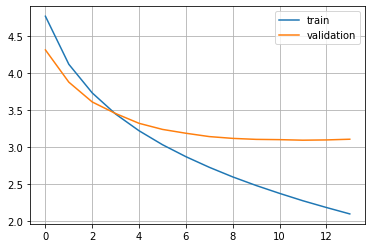

In [53]:
#시각화 하기
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.grid()
plt.show()

train의 loss값이 2.0, val loss값이 3.0으로 생각보다 낮은 수치를 띄고 있는 것 같으니 한번 headlines을 뽑아보자.

##### 인퍼런스 모델 구현하기

In [54]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('인퍼런스 구축완료:)')

인퍼런스 구축완료:)


인코더 모델 설계 

In [55]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('인코더 모델 설계 완료')

인코더 모델 설계 완료


디코더 출력층 설계

In [56]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('최종 디코더 모델 출력층 설계 완료')

최종 디코더 모델 출력층 설계 완료


In [58]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('디코더 시퀀스 생성!')

디코더 시퀀스 생성!


#### 모델 테스트하기

In [59]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('정수 -> 텍스트 시퀀스 생성:)')

정수 -> 텍스트 시퀀스 생성:)


약 10개 정도 샘플 뽑아서 요약 비교해보자

In [60]:
for i in range(0, 10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : pakistan pm shahid khaqan abbasi underwent security check us airport last month said check reduce respect prime minister instead increased adding law everyone abbasi said even seen former us president bill clinton go security checks 
실제 요약 : us airport security check increased my respect pakistan pm 
예측 요약 :  pakistan pm imran khan not to go on us pm imran khan


원문 : delhi police saturday informed total challans issued november signature bridge opened public use november stated challans riding without helmets improper parking one way violation triple riding speeding among others 
실제 요약 : issued at signature bridge in days of opening 
예측 요약 :  delhi police to get new year old in delhi


원문 : ekta kapoor announced production house balaji motion pictures producing film amul founder kurien known india film directed toilet ek prem katha director shree narayan singh adaptation book dream life kurien 
실제 요약 : ekta kapoor to produce film on amul founder 
예측 요약 :  ekta kapoor to feature i

그나마 나은 문장이 'new zealand is the most beautiful women in the world' 이라니요....  
문장들이 전부 어색하다....

Optimizer를 Adam으로 변경해서 다시 진행해보자....  
이것도 안되다면 embedding size를 줄여 더 확실하게 학습시키자...!

### 5-2) Optimizer Adam 사용

In [73]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history_2 = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 59s 174ms/step - loss: 0.9979 - val_loss: 3.5219
Epoch 2/50
307/307 [==============================] - 52s 170ms/step - loss: 0.9430 - val_loss: 3.5740
Epoch 3/50
307/307 [==============================] - 52s 170ms/step - loss: 0.9041 - val_loss: 3.6169
Epoch 3: early stopping


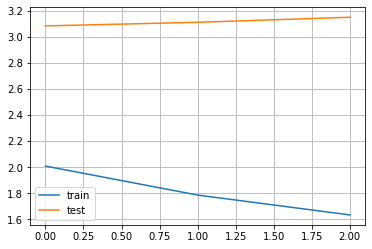

In [62]:
#시각화 하기
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='test')
plt.legend()
plt.grid()
plt.show()

와우 dropout을 시키고 Adam을 썼는데도 과적합이 나온다고요...?   
예상도 못한 몹시 당황스러운 결과다...  

우선 모델을 돌렸으니 테스트를 시켜보자

#### 모델 테스트하기

In [63]:
for i in range(0, 10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : pakistan pm shahid khaqan abbasi underwent security check us airport last month said check reduce respect prime minister instead increased adding law everyone abbasi said even seen former us president bill clinton go security checks 
실제 요약 : us airport security check increased my respect pakistan pm 
예측 요약 :  pak pm imran khan not to stop terrorism says pm abbasi


원문 : delhi police saturday informed total challans issued november signature bridge opened public use november stated challans riding without helmets improper parking one way violation triple riding speeding among others 
실제 요약 : issued at signature bridge in days of opening 
예측 요약 :  delhi police to get three public bag for people


원문 : ekta kapoor announced production house balaji motion pictures producing film amul founder kurien known india film directed toilet ek prem katha director shree narayan singh adaptation book dream life kurien 
실제 요약 : ekta kapoor to produce film on amul founder 
예측 요약 :  vaani kapoor to 

역시나 엉망진창이다...  

지금 Optimizer를 RMSProp -> Adam(RMSProp + Momentum) 으로 바꿔 진행했으니,  
마지막으로 RMSProp + NAG(관성방향으로 움직이고, 그 자리에 스텝계산)인 Nadam을 한번 사용해보고, 이때도 과적합이 일어난다면, Optimizer는 RMSProp으로 고정시키고 Embedding을 조절해보자 

### 5-3) Optimizer Nadam 사용

In [69]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam

In [71]:
model.compile(optimizer='Nadam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history_3 = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 61s 180ms/step - loss: 1.0744 - val_loss: 3.4310
Epoch 2/50
307/307 [==============================] - 54s 176ms/step - loss: 1.0147 - val_loss: 3.4848
Epoch 3/50
 48/307 [===>..........................] - ETA: 41s - loss: 0.8940

KeyboardInterrupt: ignored

In [ ]:
#시각화 하기
plt.plot(history_3.history['loss'], label='train')
plt.plot(history_3.history['val_loss'], label='test')
plt.legend()
plt.grid()
plt.show()